<a href="https://colab.research.google.com/github/parth-ds/Brainwave_Matrix_Intern/blob/main/social_media_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import files
uploaded = files.upload()


Saving NLP test.csv to NLP test.csv


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%pip install emoji
import re,string
import emoji
import nltk

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.4 MB/s eta 0:00:00


In [5]:
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

In [6]:
df=pd.read_csv('/content/NLP test.csv')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [8]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


**Tweets count by time**

In [9]:
df['TweetAt']=pd.to_datetime(df['TweetAt'], format='%d-%m-%Y')
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')
display(tweets_per_day)

,TweetAt,counts
0,03-02,4
1,03-03,4
2,03-04,8
3,03-05,6
4,03-06,2
5,03-07,7
6,03-08,9
7,03-09,16
8,03-10,54
9,03-11,165


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [10]:
df=df[['OriginalTweet','Sentiment']]

In [11]:

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_test = df_test[['OriginalTweet', 'Sentiment']]

display(df_test.head())

,OriginalTweet,Sentiment
1070,At my local grocery store in New Hampshire... ...,Neutral
354,"Seeing resellers sell masks, alcohols and othe...",Extremely Negative
881,"Where did coronavirus come from, and where wil...",Extremely Negative
196,"If you still can, stock up on dry and canned f...",Neutral
3518,Popped over at my local supermarket n it s zom...,Negative


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [12]:
def strip_emoji(text):
    # Use emoji.EMOJI_DATA for newer versions of the emoji library
    return re.sub("|".join(re.escape(e) for e in emoji.EMOJI_DATA), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [13]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [14]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [15]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test


In [16]:
df['text_clean'].head()

,text_clean
0,trending new yorkers encounter empty supermark...
1,when i couldnt find hand sanitizer at fred mey...
2,find out how you can protect yourself and love...
3,panic buying hits newyork city as anxious shop...
4,toiletpaper dunnypaper coronavirus coronavirus...


In [17]:
df_test['text_clean'].head()

,text_clean
1070,at my local grocery store in new hampshire cor...
354,seeing resellers sell masks alcohols and other...
881,where did coronavirus come from and where will...
196,if you still can stock up on dry and canned fo...
3518,popped over at my local supermarket n it s zom...


In [18]:
df['text_clean'][1:8].values

array(['when i couldnt find hand sanitizer at fred meyer i turned to amazon but 11497 for a 2 pack of purellcheck out how coronavirus concerns are driving up prices',
       'find out how you can protect yourself and loved ones from coronavirus',
       'panic buying hits newyork city as anxious shoppers stock up on foodampmedical supplies after healthcare worker in her 30s becomes bigapple 1st confirmed coronavirus patient or a bloomberg staged event qanon qanon2018 qanon2020 election2020 cdc',
       'toiletpaper dunnypaper coronavirus coronavirusaustralia coronavirusupdate covid19 9news corvid19 7newsmelb dunnypapergate costco one week everyone buying baby milk powder the next everyone buying up toilet paper',
       'do you remember the last time you paid 299 a gallon for regular gas in los angelesprices at the pump are going down a look at how the coronavirus is impacting prices 4pm',
       'voting in the age of coronavirus hand sanitizer supertuesday',
       'we cant stop covid

In [19]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [20]:
df['text_len'] = text_len

In [21]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [22]:
df_test['text_len'] = text_len_test

/tmp/ipython-input-1709064425.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')


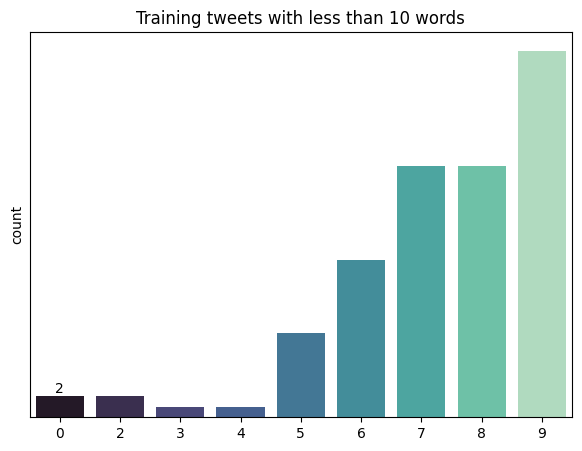

In [23]:

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

As we can see, there are lots of cleaned tweets with 0 words: this is due to the cleaning performed before. This means that some tweets contained only mentions, hashtags and links, which have been removed. We will drop these empty tweets and also those with less than 5 words.

In [24]:
print(f"DF SHAPE :{df.shape}")
print(f"DF TEST SHAPE :{df.shape}")


DF SHAPE :(3798, 4)
DF TEST SHAPE :(3798, 4)


In [25]:
df=df[df['text_len']>4]


In [26]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

df_test['text_len'] = text_len_test

TRAINING DATA DEEPER CLEANING

In [27]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [28]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [29]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 96


Let's check the long tokenized sentences (with more than 80 tokens ):

In [30]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 345, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
INDEX: 2380, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [31]:
df['token_lens'] = token_lens

In [32]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)


,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70


In [33]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
2177,Yo mama so nasty COVID won't take her\r\r\nYo ...,Extremely Negative,yo mama so nasty covid wont take her yo mama s...,53,69
3735,When there's much need of hamd sanitizers comp...,Negative,when theres much need of hamd sanitizers compa...,43,69
1895,Today I went to the supermarket for the first ...,Negative,today i went to the supermarket for the first ...,49,69
671,"Please ppl, I just want to do my normal evenin...",Positive,please ppl i just want to do my normal evening...,51,68
300,Dont let be lumped in with Toliet paper users...,Neutral,dont let be lumped in with toliet paper users ...,30,67


The dataset looks more clean now. We will shuffle it and reset the index.

In [34]:
df = df.sample(frac=1).reset_index(drop=True)

TEST DATA DEEPER CLEANING

In [35]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [36]:
print(f"MAX TOKENIZED SENTENCE LENGTH:{max_len}")

MAX TOKENIZED SENTENCE LENGTH:67


In [37]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

In [38]:
df_test['token_lens'] = token_lens_test

In [39]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
2918,obyrne EVAUK actionhunger may food union spark...,Extremely Negative,obyrne evauk actionhunger may food union spark...,56,67
3560,What's the craziest thing you've done in the l...,Negative,whats the craziest thing youve done in the las...,44,67
3045,In times like #coronavirus people at #covid19d...,Positive,in times like coronavirus people at covid19deu...,45,65
1421,"THIS #Coronovirus IS SHOWING THE ""TRUE COLORS""...",Negative,this coronovirus is showing the true colors of...,50,65
1657,"I was enlightened on the issue of ""panic-buyin...",Negative,i was enlightened on the issue of panicbuying ...,50,64
457,Trump Derangement Syndrome is spreading faster...,Negative,trump derangement syndrome is spreading faster...,36,64
2602,"Stock up on Food, Water and supplements like S...",Extremely Positive,stock up on food water and supplements like se...,42,64
2377,Well. My life is about to solely be about work...,Positive,well my life is about to solely be about work ...,60,64
1960,I went shopping today and the part of town the...,Extremely Negative,i went shopping today and the part of town the...,50,64
1064,A woman waits her turn to enter the supermarke...,Neutral,a woman waits her turn to enter the supermarke...,35,63


In [40]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
457,Trump Derangement Syndrome is spreading faster...,Negative,trump derangement syndrome is spreading faster...,36,64
2602,"Stock up on Food, Water and supplements like S...",Extremely Positive,stock up on food water and supplements like se...,42,64
2377,Well. My life is about to solely be about work...,Positive,well my life is about to solely be about work ...,60,64


In [41]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

cleaning is completed,NOW

**SENTIMENT COLUMN ANALYSIS**

In [42]:
df['Sentiment'].value_counts()

,count
Sentiment,
Negative,1038
Positive,943
Neutral,614
Extremely Positive,598
Extremely Negative,587


In [43]:
df['Sentiment']=df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [44]:
df_test['Sentiment']=df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [45]:
df['Sentiment'].value_counts()

,count
Sentiment,
0,1625
2,1541
1,614


We will proceed with oversampling the train test, to remove bias towards the majority classes.

In [46]:
from imblearn.over_sampling import RandomOverSampler

In [47]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [48]:
train_os['Sentiment'].value_counts()

,count
Sentiment,
0,1625
2,1625
1,1625


In [49]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [50]:
seed = 42 # You can change this value to any integer

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)


In [52]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values


In [53]:
MAX_LEN=128

In [54]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [55]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [56]:
bert_model=TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were 

In [57]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)


    return model

In [58]:
model=create_model(bert_model,MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

now i can start the fine tuning of BERT transformer

In [59]:
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_valid_encoded = tf.keras.utils.to_categorical(y_valid, num_classes=3)

In [60]:
# Recreate and recompile the model before fitting
model = create_model(bert_model, MAX_LEN)

history_bert = model.fit([train_input_ids,train_attention_masks], y_train_encoded, validation_data=([val_input_ids,val_attention_masks], y_valid_encoded), epochs=4, batch_size=32)

Epoch 1/4
138/138 [==============================] - 140s 849ms/step - loss: 0.9943 - categorical_accuracy: 0.5113 - val_loss: 0.8520 - val_categorical_accuracy: 0.6025
Epoch 2/4
138/138 [==============================] - 115s 836ms/step - loss: 0.6987 - categorical_accuracy: 0.7094 - val_loss: 0.6845 - val_categorical_accuracy: 0.7213
Epoch 3/4
138/138 [==============================] - 115s 837ms/step - loss: 0.4624 - categorical_accuracy: 0.8238 - val_loss: 0.5713 - val_categorical_accuracy: 0.7684
Epoch 4/4
138/138 [==============================] - 115s 837ms/step - loss: 0.2939 - categorical_accuracy: 0.8945 - val_loss: 0.5637 - val_categorical_accuracy: 0.7971


In [61]:
result_bert = model.predict([test_input_ids,test_attention_masks])

24/24 [==============================] - 10s 290ms/step


In [62]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [70]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix


In [71]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

NameError: name 'conf_matrix' is not defined

In [72]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [73]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

np.int64(73)

In [75]:
MAX_LEN=123

In [76]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [77]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [82]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)


    return model

In [79]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [83]:
model=create_model(roberta_model,MAX_LEN)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 123)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 123)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_5[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_6[0][0]']             
                             hidden_state=(None, 123, 7                                           
                             68),                                                           

In [85]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)

Epoch 1/4


ValueError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1148, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1206, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/backend.py", line 5575, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 3) are incompatible


In [86]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

24/24 [==============================] - 12s 263ms/step


In [87]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

In [88]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

NameError: name 'conf_matrix' is not defined

In [89]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

**Results Summary**

**BERT CLASSIFICATION REPORT**



In [90]:
print('Classification Report for BERT:\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

**RoBERTa classifiaction report**

In [91]:
print('Classification Report for RoBERTa:\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

AxisError: axis 1 is out of bounds for array of dimension 1

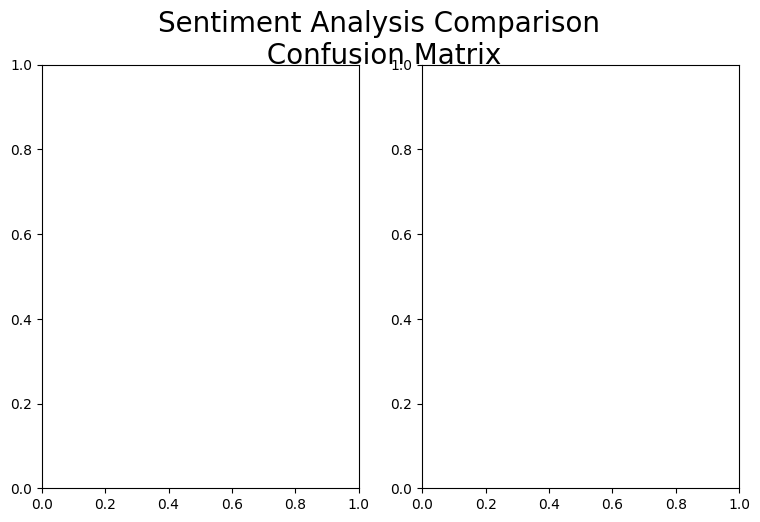

In [94]:
fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Neutral', 'Positive']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

ax[0].set_title('BERT Classifier', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17);
ax[0].set_xticklabels(labels, fontsize=17);
ax[0].set_ylabel('Test', fontsize=20)
ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_roberta.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('RoBERTa Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17);
ax[1].set_xticklabels(labels, fontsize=17);
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)


plt.show()